In [1]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
import matplotlib
import folium
import warnings
import matplotlib.ticker as ticker
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
import math
%matplotlib inline
sns.set_style("white")
plt.style.use('seaborn')
# sns.set_palette("white")

### Importing and Data Prep 

##### First lets read in the downloaded data from the state's DMV (scraped by AtlasEVHub.com) and can be downloaded here https://www.atlasevhub.com/materials/state-ev-registration-data/#data-format![image.png](attachment:image.png)

Because I will only be focusing on cars that require the use of charging stations, I am narrowing down my results to BEV's or Battery Electric vehicles and then checking to may sure my filter applied by doing a value count to ensure all vehicles are in fact battery powered. 

In [4]:
df_raw = pd.read_csv('data/fl_ev_registrations_public.csv')
df_raw = df_raw[(df_raw.Technology == 'BEV')]
df_raw.info()
df_raw['Vehicle Name'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249641 entries, 0 to 353791
Data columns (total 7 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   DMV ID                        249641 non-null  int64  
 1   DMV Snapshot (Date)           249641 non-null  object 
 2   County                        249641 non-null  object 
 3   Vehicle Name                  249641 non-null  object 
 4   Registration Valid Date       249641 non-null  object 
 5   Registration Expiration Date  0 non-null       float64
 6   Technology                    249641 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 15.2+ MB


Tesla Model 3                    91019
Tesla Model S                    59058
Tesla Model X                    30887
Tesla Model Y                    18856
Nissan Leaf                      16295
Chevrolet Bolt EV                 8484
BMW i3                            6282
Smart forTwo EV                   4695
Audi e-tron                       2738
Porsche Taycan                    2052
Fiat 500e                         1948
Jaguar I-Pace                     1898
Volkswagen ID.4                    611
Ford Focus EV                      607
Volkswagen e-Golf                  552
Chevrolet Spark                    492
Smart forTwo EV Cabrio             438
Audi e-tron Sportback              373
Mercedes B-Class Electric          344
Kia Soul EV                        313
Tesla Roadster                     295
Mitsubishi i                       288
Kia Niro EV                        280
Hyundai Kona Electric              170
Ford Mustang Mach-E                156
Mini Hardtop 2 Door EV   

For my analyses, since my primary focus is the growth of electric vehicles, I will create a new dataframe based on the count of vehicles being registered per year. 

In [6]:
years = pd.DataFrame(df_raw['Registration Valid Date'].value_counts().reset_index().values, columns=["Year", "Registered Vehicles"])
years.head()

,Year,Registered Vehicles
0,7/19/2021,70279
1,12/31/2020,52877
2,6/30/2020,43123
3,12/31/2019,39789
4,12/31/2018,25458


,Registered Vehicles
Year,
2018-06-30,18115.0
2018-12-31,25458.0
2019-12-31,39789.0
2020-06-30,43123.0
2020-12-31,52877.0
2021-07-19,70279.0


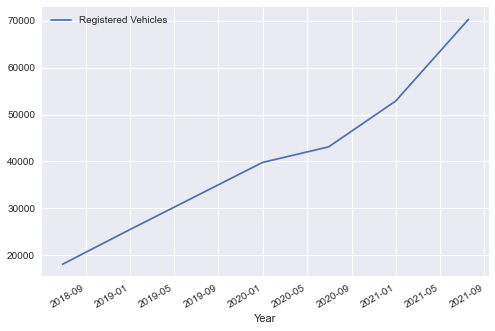

In [7]:
df = pd.DataFrame(years['Registered Vehicles']).set_axis(pd.to_datetime(years['Year'])).sort_values(by=['Year'], ascending = True).astype(float)
df.plot()
df

I converted my new data using the datetime index function (which will be necessary for time series forecasting) then plotted. Here we see an upwards trend of EV's on the road from 2018 to 2021 as expected due to the surge of electric vehicles on the road these past few years. 

### RESAMPLING

To make our data more granular, I decided to resample up to monthly. After trying Interpolate with backfill and plan backfill, I decided front fill was the best to work with as the data show contains a strong upwards trend. 

In [8]:
# # Interpolate - Backfill 
# df = df.resample('M').interpolate(method = 'linear')
# df = df.bfill()
# df.plot()

# # Backfill 
# df = df.resample('M').bfill()
# df.plot()

<AxesSubplot:xlabel='Year'>

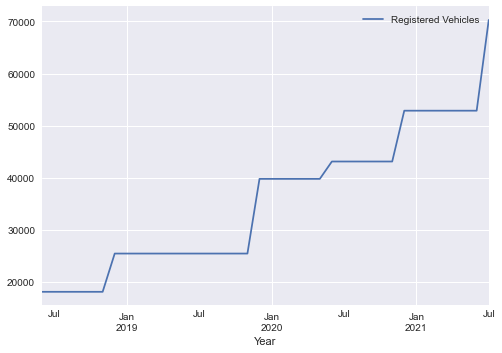

In [9]:
# #Frontfill 
df = df.resample('M').ffill()
df.plot()

In [11]:
adtest = adfuller(df)
display(adtest)

(0.5358231579571177,
 0.9859221885122601,
 0,
 37,
 {'1%': -3.6209175221605827,
  '5%': -2.9435394610388332,
  '10%': -2.6104002410518627},
 534.4673722813862)

We already know our data is not stationary as it exhibits an strong upwards trend, but to be certain we can check with the Dickey-Fuller test. With a  p-value of .98592, we fail to reject the null confirming that our data is not stationary. 

### Baseline model 

Since we know that our data is not stationary and that I will be modeling 15 other states, I decided to use SARIMA (Seasonal ARIMA) to account for the 'seasonality' or trend. 

In [10]:
auto_model = pm.auto_arima(df, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=911.314, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=890.482, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=753.764, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=755.866, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=889.383, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=754.058, Time=0.04 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.487 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   38
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -373.882
Date:    

After utilizing auto modeling, we see the best ARIMA model for our data is Best model:  

ARIMA(1,0,1)(0,0,0)[0] with an AIC of 753.764

### Modeling

Next, we're going to do a train/test split to improve our model's performance. 2018-2020 will be our training data, leaving 2021 to be our test or validation data set

In [32]:
train = df['2018':'2020-12-31']
test = df['2020-12-31':]
combined = df
test

,Registered Vehicles
Year,
2020-12-31,52877.0
2021-01-31,52877.0
2021-02-28,52877.0
2021-03-31,52877.0
2021-04-30,52877.0
2021-05-31,52877.0
2021-06-30,52877.0
2021-07-31,70279.0


In [13]:
naive = train.shift(1)
np.sqrt(mean_squared_error(train[1:], naive.dropna()))

3490.717605306966

Again using auto modeling to find best model for training set

In [14]:
auto_model = pm.auto_arima(train, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=734.520, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=718.797, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=604.542, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=606.576, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=718.928, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=604.595, Time=0.03 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.444 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   31
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -299.271
Date:    

### The best model is still :  ARIMA (1,0,1) (0,0,0) [0]

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0342      0.029     36.238      0.000       0.978       1.090
ma.L1         -0.1930      0.601     -0.321      0.748      -1.371       0.985
sigma2      1.195e+07   3.36e-08   3.55e+14      0.000    1.19e+07    1.19e+07


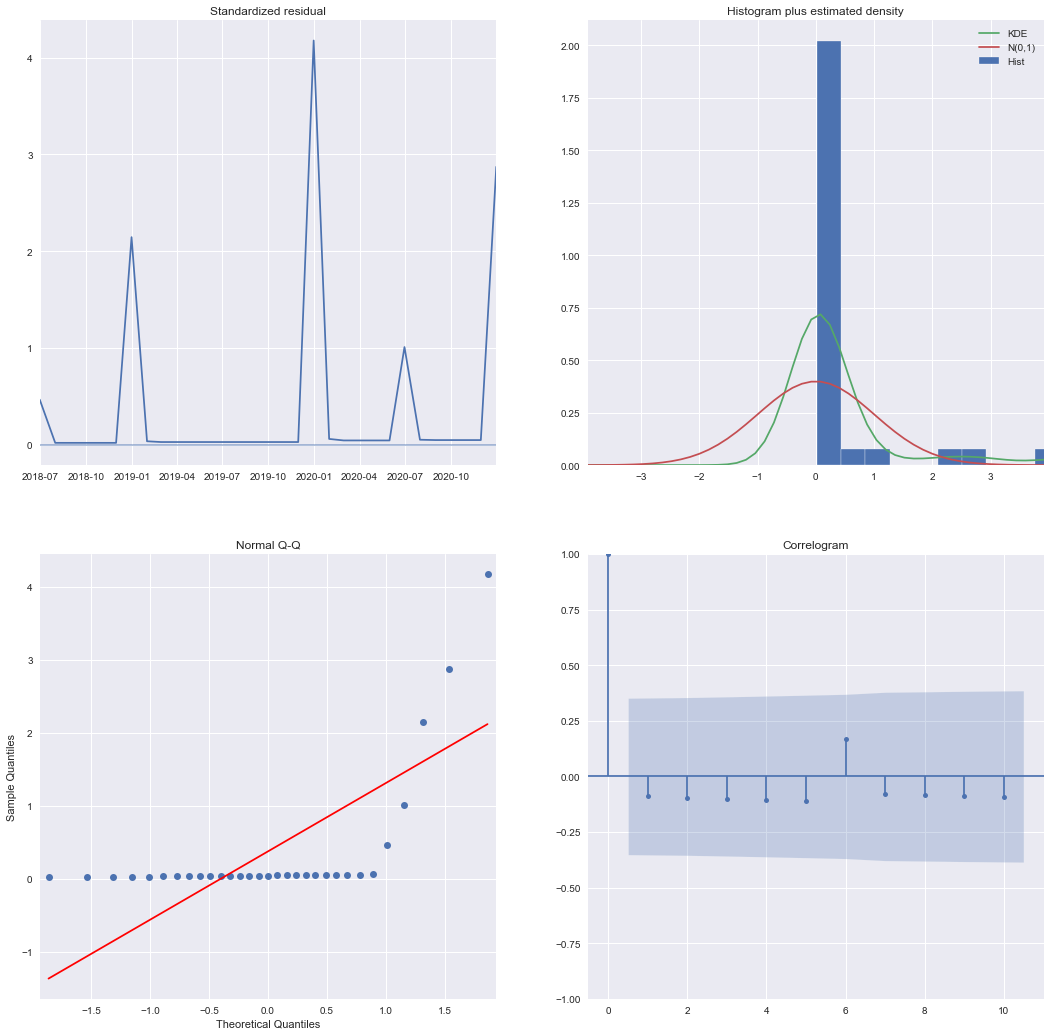

In [15]:
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(train, 
                                        order=(1,0,1), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)
output = ARIMA_MODEL.fit()
print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

Due to the limited data we have to work with and reporting frequency, there are spikes in our extreme values. Here we see the standardized residuals and Q-Q plots showing our data lacks homoscedasticity and normality. 

In [34]:
pred = output.get_prediction(start=pd.to_datetime('2020-12-31'), end=pd.to_datetime('2021-07-19'), dynamic=False)
pred_conf = pred.conf_int()
print(pred_conf)

            lower Registered Vehicles  upper Registered Vehicles
2020-12-31               38177.553300               51725.869546
2021-01-31               46383.022013               59931.338259
2021-02-28               46124.220352               63828.827542
2021-03-31               46223.368764               67492.903528
2021-04-30               46546.430906               71061.864921
2021-05-31               47033.015757               74600.510992
2021-06-30               47650.357679               78146.166495
2021-07-31               48378.721302               81723.281965


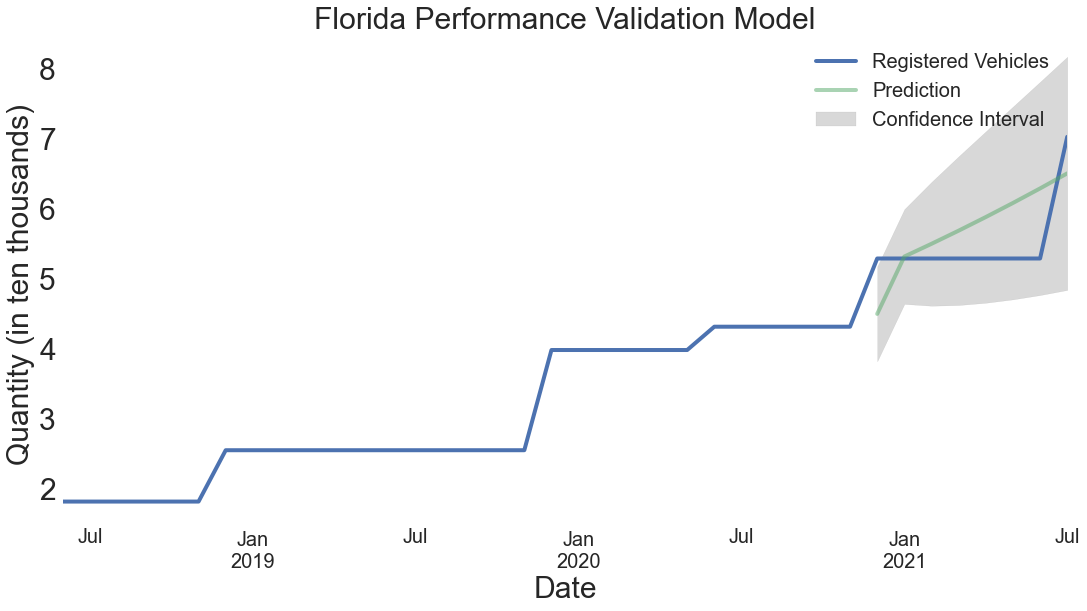

In [23]:
sns.set_style(style='white')
rcParams['figure.figsize'] = 18, 9
ax = df.plot(label='observed', linewidth = 4)
pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=0.5, linewidth = 4)
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='grey', alpha=0.3,label = 'Confidence Interval')
ax.set_xlabel('Date',fontsize=30)
plt.xticks(fontsize=20)
ax.set_ylabel('Quantity (in ten thousands) ',fontsize=30)
ax.tick_params(axis='x', which='minor', labelsize=20)
plt.yticks(fontsize=30)
scale_y = 1e4
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Florida Performance Validation Model',fontsize=30)
plt.legend(fontsize = 20)
plt.show()

Although there is some distance between our predictions and the actual results, we see that there is some interception as well so model is not overfitting and is within 95 confidence interval

In [41]:
MSE = mean_squared_error(test, pred_conf['lower Registered Vehicles']) 
RMSE = math.sqrt(MSE)
print(RMSE)

10777.781420744881


The high RMSE may be due to the rate/data reporting frequency (6 month updates).  
Last reported value for July 2021: 70,279  
Predicted values for July 2021: 48378.721302(lower), 81723.281965(upper) 

### Forecasting for 2025

Now lets forecast the amount of EV's that will be on the road by 2025. 

In [26]:
# Beginning our forecasting for next 4 years (48 months)
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(combined, 
                                        order=(1,0,1), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)
full_output = ARIMA_MODEL.fit()
print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0342      0.029     36.238      0.000       0.978       1.090
ma.L1         -0.1930      0.601     -0.321      0.748      -1.371       0.985
sigma2      1.195e+07   3.36e-08   3.55e+14      0.000    1.19e+07    1.19e+07


In [27]:
# Taking mean of upper and lower limits of prediction 
forecast = full_output.get_forecast(48)
future_prediction = forecast.conf_int()
future_prediction['value'] = forecast.predicted_mean
future_prediction.columns = ['lower','upper','prediction'] 
future_prediction

,lower,upper,prediction
2021-08-31,55555.288059,71934.492751,63744.890405
2021-09-30,57696.230166,74096.573666,65896.401916
2021-10-31,59909.079409,76331.982672,68120.531040
2021-11-30,62196.240063,78643.217457,70419.728760
2021-12-31,64560.196206,81032.861362,72796.528784
2022-01-31,67003.514338,83503.586337,75253.550337
2022-02-28,69528.846099,86058.156001,77793.501050
2022-03-31,72138.931076,88699.428802,80419.179939
2022-04-30,74836.599700,91430.361285,83133.480493
2022-05-31,77624.776248,94254.011477,85939.393862


### Prediction: as of August of 2025 there will be 303397 EV's on the road

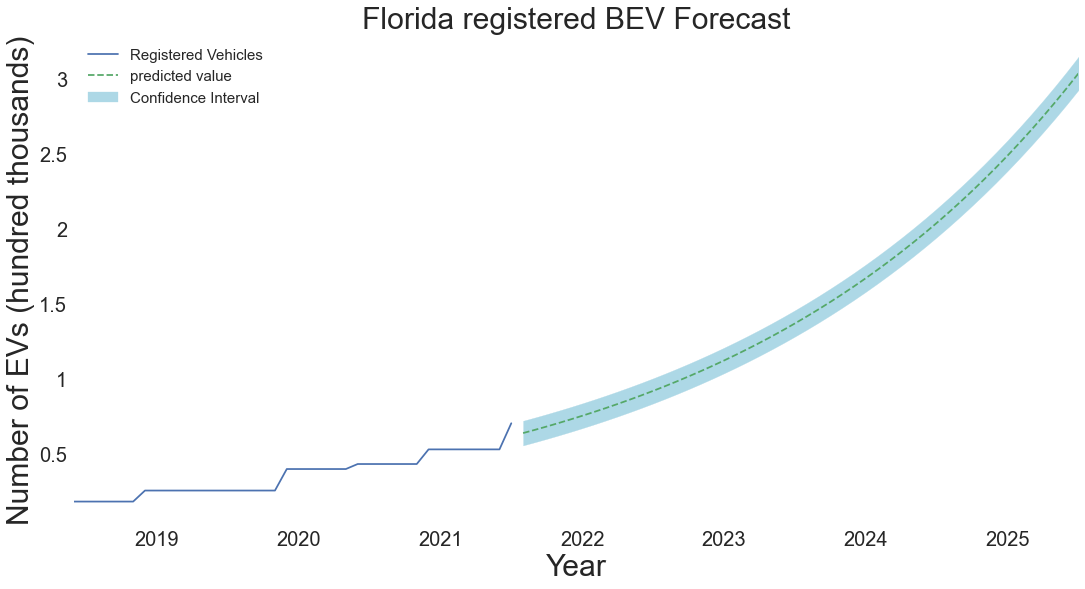

In [30]:
sns.set_style(style='white')
fig, ax = plt.subplots()
combined.plot(ax=ax,label='Actual')
future_prediction['prediction'].plot(ax=ax,label='predicted value',ls='--')
ax.fill_between(x= future_prediction.index, y1= future_prediction['lower'], 
                y2= future_prediction['upper'], color = 'lightblue',
                label='Confidence Interval')
ax.set_xlabel('Year',fontsize=30)
plt.xticks(fontsize=20)
ax.set_ylabel('Number of EVs (hundred thousands)',fontsize=30)
plt.yticks(fontsize=20)
scale_y = 1e5
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Florida registered BEV Forecast',fontsize=30)
plt.legend(fontsize = 15)
plt.show()